In [1]:

# importamos las librerías que necesitamos

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualización
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluar linealidad de las relaciones entre las variables
# y la distribución de las variables
# ------------------------------------------------------------------------------
import scipy.stats as stats

# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

# Gestión de los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

from scipy.stats import chi2_contingency, ttest_ind

In [2]:
df = pd.read_csv("files/marketing_AB.csv")
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


Ejercicio 1:
Supongamos que estamos realizando un experimento para determinar si un nuevo diseño de anuncio (test group "ad") tiene un impacto significativo en la tasa de conversión en comparación con el diseño de anuncio anterior (test group "psa").

Objetivo del ejercicio: Comparar las tasas de conversión entre los grupos de prueba "ad" y "psa" para determinar si el nuevo diseño de anuncio es más efectivo en la conversión de usuarios.

Pasos que debemos seguir:

Preparación de los datos: Asegúrate de que los datos estén limpios y listos para el análisis. Esto incluye la eliminación de datos faltantes y la verificación de la coherencia de los datos.

Definición de las hipótesis: Plantea una hipótesis nula (H0) y una hipótesis alternativa (H1) para el experimento (en este caso os las damos definidas):

Hipótesis nula (H0): No hay diferencia significativa en la tasa de conversión entre los grupos de prueba "ad" y "psa".

Hipótesis alternativa (H1): Existe una diferencia significativa en la tasa de conversión entre los grupos de prueba "ad" y "psa".



In [3]:
# una vez que tengamos nuestro DataFrame preparado con todas las columnas que queremos vamos a crear una función que no haga una exploración inicial del conjunto de datos
def exploracion_dataframe(dataframe, columna_control):
    """
    Realiza un análisis exploratorio básico de un DataFrame, mostrando información sobre duplicados,
    valores nulos, tipos de datos, valores únicos para columnas categóricas y estadísticas descriptivas
    para columnas categóricas y numéricas, agrupadas por la columna de control.

    Parámetros:
    - dataframe (DataFrame): El DataFrame que se va a explorar.
    - columna_control (str): El nombre de la columna que se utilizará como control para dividir el DataFrame.

    Returns: 
    No devuelve nada directamente, pero imprime en la consola la información exploratoria.
    """
    
    print(f"Los duplicados que tenemos en el conjunto de datos son: {dataframe.duplicated().sum()}")
    print("\n ..................... \n")
    
    
    # generamos un DataFrame para los valores nulos
    print("Los nulos que tenemos en el conjunto de datos son:")
    df_nulos = pd.DataFrame(dataframe.isnull().sum() / dataframe.shape[0] * 100, columns = ["%_nulos"])
    display(df_nulos[df_nulos["%_nulos"] > 0])
    
    print("\n ..................... \n")
    print(f"Los tipos de las columnas son:")
    display(pd.DataFrame(dataframe.dtypes, columns = ["tipo_dato"]))
    
    
    print("\n ..................... \n")
    print("Los valores que tenemos para las columnas categóricas son: ")
    dataframe_categoricas = dataframe.select_dtypes(include = "O")
    
    for col in dataframe_categoricas.columns:
        print(f"La columna {col.upper()} tiene las siguientes valore únicos:")
        display(pd.DataFrame(dataframe[col].value_counts()).head())    
    
    # como estamos en un problema de A/B testing y lo que realmente nos importa es comparar entre el grupo de control y el de test, los principales estadísticos los vamos a sacar de cada una de las categorías
    
    for categoria in dataframe[columna_control].unique():
        
        dataframe_filtrado = dataframe[dataframe[columna_control] == categoria]
    
        print("\n ..................... \n")
        print(f"Los principales estadísticos de las columnas categóricas para el {categoria} son: ")
        display(dataframe_filtrado.describe(include = "O").T)
        
        print("\n ..................... \n")
        print(f"Los principales estadísticos de las columnas numéricas para el {categoria} son: ")
        display(dataframe_filtrado.describe().T)

In [4]:
exploracion_dataframe(df, "converted")

Los duplicados que tenemos en el conjunto de datos son: 0

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


,%_nulos



 ..................... 

Los tipos de las columnas son:


,tipo_dato
Unnamed: 0,int64
user id,int64
test group,object
converted,bool
total ads,int64
most ads day,object
most ads hour,int64



 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna TEST GROUP tiene las siguientes valore únicos:


,test group
ad,564577
psa,23524


La columna MOST ADS DAY tiene las siguientes valore únicos:


,most ads day
Friday,92608
Monday,87073
Sunday,85391
Thursday,82982
Saturday,81660



 ..................... 

Los principales estadísticos de las columnas categóricas para el False son: 


,count,unique,top,freq
test group,573258,2,ad,550154
most ads day,573258,7,Friday,90551



 ..................... 

Los principales estadísticos de las columnas numéricas para el False son: 


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,573258.0,2.968963e+05,169487.824729,0.0,150842.25,298662.5,443543.75,588100.0
user id,573258.0,1.310672e+06,202374.977269,900000.0,1142997.25,1313763.5,1484277.75,1654483.0
total ads,573258.0,2.329150e+01,40.863176,1.0,4.00,13.0,26.00,2065.0
most ads hour,573258.0,1.445376e+01,4.843338,0.0,11.00,14.0,18.00,23.0



 ..................... 

Los principales estadísticos de las columnas categóricas para el True son: 


,count,unique,top,freq
test group,14843,2,ad,14423
most ads day,14843,7,Monday,2857



 ..................... 

Los principales estadísticos de las columnas numéricas para el True son: 


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,14843.0,1.841215e+05,141869.764572,15.0,73172.0,147792.0,258730.0,587665.0
user id,14843.0,1.311490e+06,196390.109537,900021.0,1150466.0,1311497.0,1476478.0,1654460.0
total ads,14843.0,8.388776e+01,87.455498,1.0,35.0,64.0,103.0,1778.0
most ads hour,14843.0,1.506016e+01,4.445566,0.0,12.0,15.0,18.0,23.0


Cálculo de la tasa de conversión: Calcula la tasa de conversión para cada grupo:

Para el grupo "ad", la tasa de conversión es el número de usuarios convertidos dividido por el número total de usuarios en ese grupo.

Para el grupo "psa", realiza el mismo cálculo.

Este es un problema de proporciones pero igual calcularemos las tasas ya que las habeis pedido.

In [5]:
df_ad = df[df["test group"] == "ad"]


In [6]:
df_psa = df[df["test group"] == "psa"]

In [7]:
df_ad["tc"] =len(df_ad[df_ad["converted"] == True])/len(df_ad)
print ("tasa grupo ad", df_ad["tc"][0])

tasa grupo ad 0.025546559636683747


In [8]:
df_psa["tc"] =len(df_psa[df_psa["converted"] == True])/len(df_psa)
df_psa["tc"].head(1)

18    0.017854
Name: tc, dtype: float64

Prueba de hipótesis: Utiliza una prueba estadística, como la prueba t de Student o la prueba chi-cuadrado, para comparar las tasas de conversión entre los grupos "ad" y "psa".

Análisis de resultados:

Si el valor p es menor que un umbral predefinido (por ejemplo, 0.05), rechazamos la hipótesis nula y concluimos que hay una diferencia significativa en las tasas de conversión entre los grupos.

Si el valor p es mayor que el umbral, no podemos rechazar la hipótesis nula y concluimos que no hay evidencia suficiente para afirmar que hay una diferencia significativa.

Conclusiones y recomendaciones: Basándote en los resultados de la prueba de hipótesis, llega a una conclusión sobre si el nuevo diseño de anuncio es más efectivo en la conversión de usuarios que el diseño anterior. Si es así, puedes hacer recomendaciones basadas en estos hallazgos.

#El siguiente es un problema de proporciones asi que realizamos la prueba de chi-cuadrado:

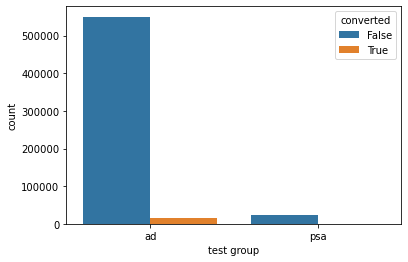

In [7]:
sns.countplot(x = "test group", hue = "converted", data = df);

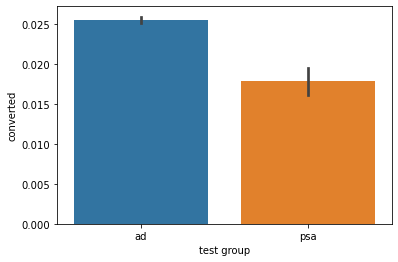

In [8]:
sns.barplot(x = "test group", y = "converted", data = df);

In [9]:
tabla_cont = pd.crosstab(df["test group"], df["converted"])

tabla_cont

converted,False,True
test group,,
ad,550154,14423
psa,23104,420


In [10]:
chi2, p_value, _, _ = chi2_contingency(tabla_cont)

print(p_value)

1.9989623063390075e-13


P_value es menor que 0.05 asi que rechazamos la hipotesis nula es decir que hay difencia significativa entre la tasa de conversion delos grupos ad y psa, el nuevo anuncio ad es mas efectivo en la tasa de conversión por lo que sugerimos a la empresa realizar el nuevo anuncio.

Ejercicio 2:
En este caso, vamos a realizar un experimento para comparar la cantidad promedio de anuncios vistos por los usuarios en los grupos "ad" y "psa" y determinar si hay una diferencia significativa entre ellos.

Objetivo del experimento: Comparar la cantidad promedio de anuncios vistos por usuario entre los grupos de prueba "ad" y "psa" para determinar si el tipo de anuncio afecta la cantidad de anuncios que los usuarios ven.

Preparación de los datos: Asegúrate de que los datos estén limpios y listos para el análisis. Esto incluye la eliminación de datos faltantes y la verificación de la coherencia de los datos.

Hipótesis: Plantea una hipótesis nula (H0) y una hipótesis alternativa (H1) para el experimento. En este caso, las deberéis plantear vosotras

Prueba de hipótesis: Utiliza una prueba estadística, como la prueba t de Student, para comparar la cantidad promedio de anuncios vistos por usuario entre los grupos "ad" y "psa". Esto te permitirá determinar si hay una diferencia significativa entre los dos grupos.

Análisis de resultados:

Si el valor p (p-value) es menor que un umbral predefinido (por ejemplo, 0.05), rechazamos la hipótesis nula y concluimos que hay una diferencia significativa en la cantidad promedio de anuncios vistos por usuario entre los grupos.

Si el valor p es mayor que el umbral, no podemos rechazar la hipótesis nula y concluimos que no hay evidencia suficiente para afirmar que hay una diferencia significativa.

Conclusiones y recomendaciones: Basándote en los resultados de la prueba de hipótesis, llega a una conclusión sobre si el tipo de anuncio (ad o psa) tiene un impacto significativo en la cantidad promedio de anuncios vistos por usuario. Si es así, puedes hacer recomendaciones basadas en estos hallazgos.

Revisamos en la exploración inicial que los datos están limpios. Plantearemos las siguientes hipótesis:
Hipótesis nula (H0): No hay diferencia significativa ente el promedio de anuncios vistos por usuario entre los grupos de prueba  "ad" y "psa".

Hipótesis alternativa (H1): Hay diferencia significativa ente el promedio de anuncios vistos por usuario entre los grupos de prueba  "ad" y "psa".
En este caso planteamos un problema de medias:

In [ ]:
df["total ads"].value_counts

In [11]:
ad_mean = df_ad["total ads"].mean()
psa_mean = df_psa["total ads"].mean()
print(f"Media de ad: {ad_mean}")
print(f"Media de psa:: {psa_mean}")

Media de ad: 24.823365103431417
Media de psa:: 24.761137561639178


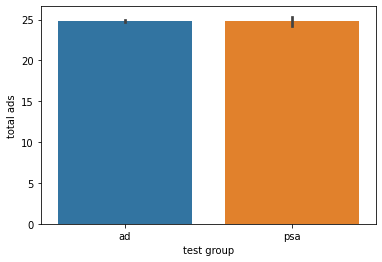

In [42]:
sns.barplot(data = df, y = "total ads", x = "test group");

Normalidad
- H0: Datos normales
- H1: NO normales

p_value > 0.05 no rechazamos H0 --> datos normales


In [12]:
from scipy.stats import shapiro, levene, mannwhitneyu

In [13]:
_,p_value = shapiro(df["total ads"])
print(f"p-Value: {p_value}")

p-Value: 0.0


En este caso los datos no son normales asi que aplicamos otro metodo.

In [14]:
statistic, p_value = mannwhitneyu(df_psa["total ads"], df_ad["total ads"])

# Imprimir los resultados
print("Estadístico de la prueba de Mann-Whitney U:", statistic)
print("Valor p:", p_value)

Estadístico de la prueba de Mann-Whitney U: 6472821126.0
Valor p: 4.6909108547205694e-11


Rechazamos la hipotesis nula es decir que hay diferencia significativa ente el promedio de anuncios vistos por usuario entre los grupos de prueba  "ad" y "psa", siendo el grupo ad donde mas anuncios se ven.